## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [1]:
# import libraries
import re
import numpy as np
import pandas as pd
import assets.script as scr
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [2]:
# import sql library
from psycopg2 import sql

# define paths
from pathlib import Path
data_path = Path('./data')

In [3]:
# display table names
display_tables = scr.read_tables()

In [4]:
# take samples from each table
flights = 'flights'
flights_test = 'flights_test'
fuel_comsumption = 'fuel_comsumption'
pass_sample = 'pass_sample'
passengers = 'passengers'
sample = 'sample'
test_table = 'test_table'

# for mass data gathering loop
table_names = [flights, flights_test, fuel_comsumption, pass_sample, passengers, sample, test_table]

In [5]:
# query for tables
sample_size = '100k'

for tables in table_names:
    query = sql.SQL(
        "SELECT * FROM {table} \
            LIMIT %s;").format(
            table = sql.Identifier(tables),
        )
        
    filename = '{}_{}_sample.csv'.format(tables, sample_size)
    limit = (100000, )
    overwrite = False
    
    # sql call
    df = scr.make_csv(query, filename, limit, overwrite)

File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...


In [6]:
# transfer sample of tables to dataframes
df_flights = pd.read_csv(data_path / 'flights_{}_sample.csv'.format(sample_size))
df_flights_test = pd.read_csv(data_path / 'flights_test_{}_sample.csv'.format(sample_size))
df_fuel_comsumption = pd.read_csv(data_path / 'fuel_comsumption_{}_sample.csv'.format(sample_size))
df_pass_sample = pd.read_csv(data_path / 'pass_sample_{}_sample.csv'.format(sample_size))
df_passengers = pd.read_csv(data_path / 'passengers_{}_sample.csv'.format(sample_size))
df_sample = pd.read_csv(data_path / 'sample_{}_sample.csv'.format(sample_size))
df_test_table = pd.read_csv(data_path / 'test_table_{}_sample.csv'.format(sample_size))

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

##### Look for columns describing delay

In [7]:
# search for columns that describe delays
regex = r"(.*delay.*)"
indices, results = scr.search_data(df_flights, regex)
results

['dep_delay',
 'arr_delay',
 'carrier_delay',
 'weather_delay',
 'nas_delay',
 'security_delay',
 'late_aircraft_delay']

##### Preliminary EDA

In [8]:
print(df_flights[results].isnull().sum())
# most delays appear to have many missing values; will ignore them for now

# early arrivals|departures without null values
df_flights_delay = df_flights[['dep_delay', 'arr_delay']].dropna().reset_index(drop=True)
print(df_flights_delay.isnull().sum())
print(df_flights_delay.index)
df_flights_delay.describe()

dep_delay               3133
arr_delay               3723
carrier_delay          73689
weather_delay          73689
nas_delay              73689
security_delay         73689
late_aircraft_delay    73689
dtype: int64
dep_delay    0
arr_delay    0
dtype: int64
RangeIndex(start=0, stop=96277, step=1)


,dep_delay,arr_delay
count,96277.000000,96277.000000
mean,21.840512,17.573450
std,68.435427,70.287878
min,-32.000000,-88.000000
25%,-5.000000,-13.000000
50%,-1.000000,-3.000000
75%,17.000000,18.000000
max,1615.000000,1597.000000


These numbers are terrible.

##### Check for normal distributions

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.46445733308792114 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 16281.315486526786 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 6.635684409030094
kurtosis, tail spread (< 3 is best): 73.27290163045704


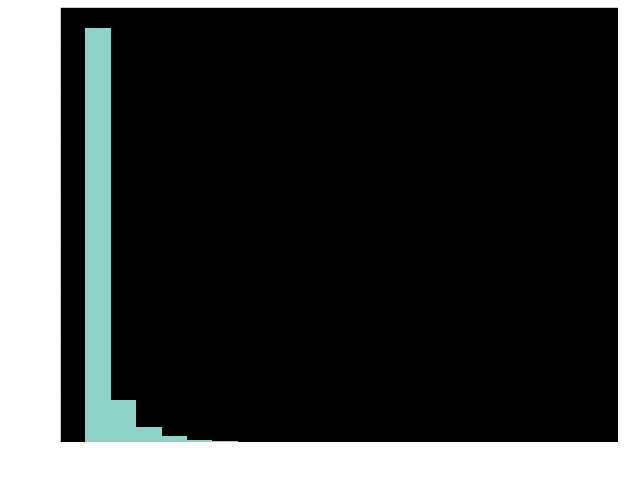

In [9]:
scr.check_normal_dist(df_flights_delay['dep_delay'])

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.5947854518890381 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 12638.842786035922 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 6.209374232134813
kurtosis, tail spread (< 3 is best): 66.36765450338011


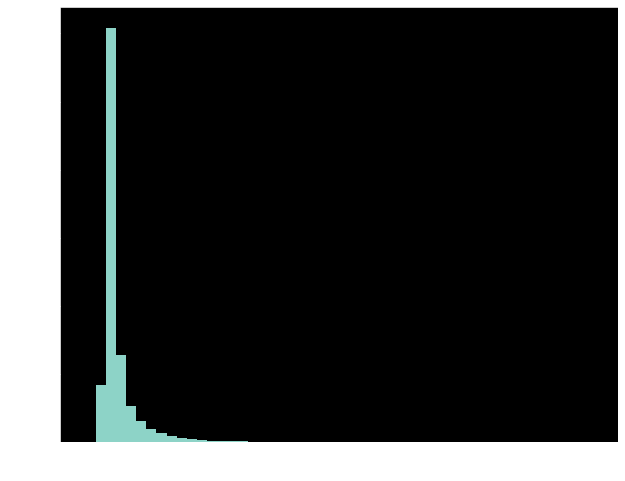

In [10]:
scr.check_normal_dist(df_flights_delay['arr_delay'], bins=50)

These are really not normal. Also, extremely skewed.

##### Filter outliers and redo the normal distribution checks

In [11]:
df = scr.filter_outliers(df_flights_delay, df_flights_delay['arr_delay'])
df.reset_index(inplace=True, drop=True)
df = scr.filter_outliers(df, df['dep_delay'])

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.8135808706283569 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 5865.607979487759 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 1.9776802142480534
kurtosis, tail spread (< 3 is best): 4.470678047775033


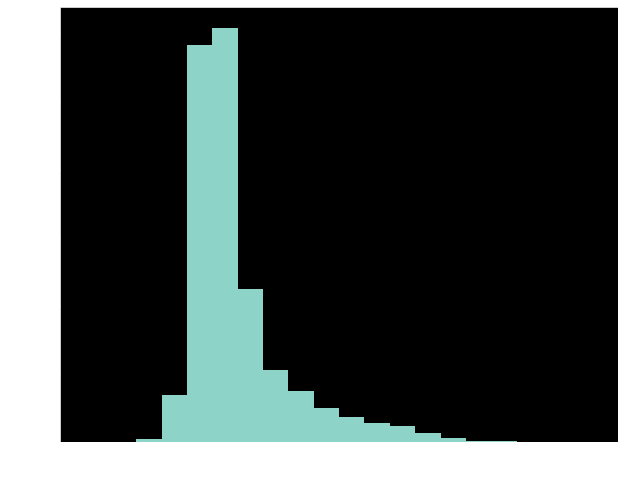

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.6654062867164612 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 10910.59739584144 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.32689942902098
kurtosis, tail spread (< 3 is best): 5.215487610741231


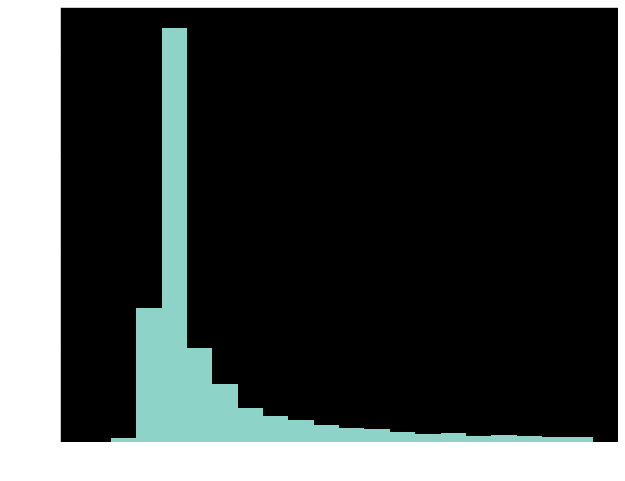

,dep_delay,arr_delay
count,91502.000000,91502.000000
mean,9.956176,5.643308
std,27.637826,31.450826
min,-32.000000,-88.000000
25%,-5.000000,-13.000000
50%,-1.000000,-4.000000
75%,12.000000,13.000000
max,135.000000,227.000000


In [12]:
scr.check_normal_dist(df['arr_delay'])
scr.check_normal_dist(df['dep_delay'])
df.describe()

These are much better. The mean trends closer to zeo, and the max values aren't nearly so bad. Though, it still skews positive, these numbers make more sense.

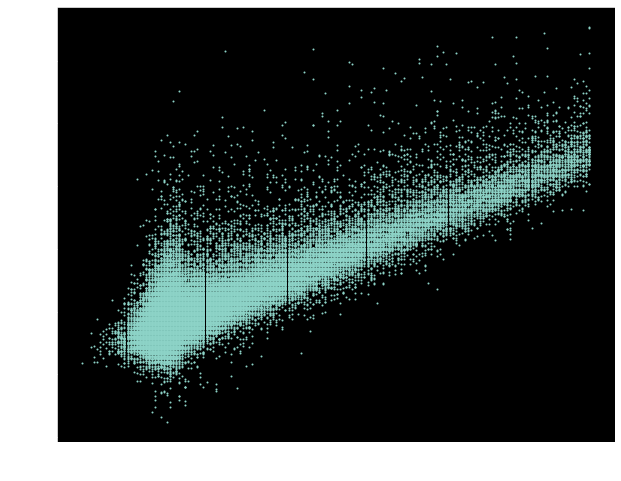

In [18]:
scr.graph_eda('scatter', df['dep_delay'], df['arr_delay'], marker_size=1)

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?